# GraphRAG Retrieval Evaluation

## Purpose
The code implements an enhanced document retrieval system that combines vector similarity search with graph-based traversal to find relevant document chunks. Here's a detailed breakdown:

1. **Vector Search & Similarity Scoring**
 - Converts the input query into a vector embedding
 - Performs similarity search against entity nodes in Neo4j
 - Creates a sorted dictionary of entity IDs and their similarity scores
 - Filters results based on a similarity threshold (default 0.8)

2. **Graph Traversal Strategy**
```sql
    MATCH path = (n:Chunk)-[*1..{max_hops}]->(m:`__Entity__`)
    WHERE m.id IN $ids
```
 - Finds paths from document chunks to relevant entities
 - Limits path length to control traversal depth
 - Only considers entities that met the similarity threshold

3. **Relevance Calculation**
```sql
    WITH n, min(length(path)) as distance, m
    WITH n, distance, m.id as entity_id
    WITH n, distance, entity_id, 
            CASE 
            WHEN entity_id IN $ids 
            THEN $similarity_scores[entity_id]
            END as similarity
```
 - Calculates shortest path length to each entity
 - Preserves original similarity scores from vector search
 - Combines structural proximity (distance) with semantic similarity

4. **Result Ordering**
```sql
    ORDER BY similarity DESC, distance
```
 - Prioritizes chunks with higher semantic similarity
 - Uses path distance as a secondary sorting criterion
 - Ensures most relevant chunks appear first

5. **Output Format**
```sql
    RETURN n.text, n.fileName, n.page_number, n.position, entity_id, similarity
```
 - Returns comprehensive chunk metadata:
    - Text content
    - Source file name
    - Page number
    - Position in document
    - Associated entity ID
    - Similarity score

## Key Features
- Hybrid retrieval approach combining:
    - Vector-based semantic search
    - Graph-based structural relationships
- Configurable parameters:
    - Similarity threshold
    - Maximum path length
    - Result limit
- Deduplication of chunks
- Ordered results by relevance
- Rich metadata for each chunk

## Step 0: environment set up

In [1]:
from dotenv import load_dotenv

import os
from langchain_neo4j import Neo4jGraph
from libs import create_vector_index
import pandas as pd
from conn import connect2Googlesheet,retrieval_rel_docs, get_avg_similarity_df,get_concatenate_df,clean_retrieved_files,apply_metrics,plot_metrics_and_roc
from libs import context_builder, chunk_finder, enhanced_chunk_finder
# Force reload of the .env file
load_dotenv()

True

In [2]:
# Connect to Neo4j database
try:
    graph = Neo4jGraph(
        url=os.getenv("NEO4J_URL"),
        username=os.getenv("NEO4J_USERNAME"),
        password=os.getenv("NEO4J_PASSWORD")
    )
    print("Connected to Neo4j database successfully.")
except ValueError as e:
    print(f"Could not connect to Neo4j database: {e}")

Connected to Neo4j database successfully.


## Step 1: Create vector index

In [3]:
create_vector_index(graph, "entities")

✅ Index 'entities' already exists with correct dimensions: 384


## Step 2: Load questions from google sheet

In [4]:
spreadsheet = connect2Googlesheet()

# Select the worksheet: relevance
worksheet = spreadsheet.get_worksheet(2)  

# Get all records as a list of dictionaries
data = worksheet.get_all_records()

# Convert to Pandas DataFrame
df_MedQ = pd.DataFrame(data)
df_MedQ.head()

,condition,number,docs,Question,Mahmud's Note,status,comments,
0,ARDS,1,ACURASYS,Does early administration of neuromuscular blo...,Like,,,
1,ARDS,2,ACURASYS,Do patients with severe ARDS being treated wit...,Replace,fixed,,
2,ARDS,3,ROSE,"In patients with moderate to severe ARDS, does...",Maybe this question: In patients with moderate...,fixed,,
3,ARDS,4,ROSE,Do patients with moderate-to-severe ARDS have ...,Local question (not sure if this is the aim of...,fixed,Wrong concept since PEEP by itself is mandator...,Does the use of neuromuscular blockers in pati...
4,ARDS,5,FACTT,"Among patients with ALI/ARDS, does a conservat...",Local question (not sure if this is the aim of...,fixed,Check if studies defined conservative by CVP <...,


## Step 3: Relevance check for top K questions

The [*1..{max_hops}] syntax in the Cypher query defines a variable-length relationship pattern in Neo4j.
**Syntax Explanation**
- `*` indicates a variable-length path
- 1..{max_hops} specifies the range:
    - 1 is the minimum length
    - {max_hops} is the maximum length (passed as a parameter)

**Purpose**
1. Path Flexibility: It allows finding relationships between nodes that are both:
    - Directly connected (1 hop)
    - Indirectly connected (up to max_hops steps away)
2. Example with max_hops=2:
```python
    (Chunk)-->(Entity)           // 1 hop
    (Chunk)-->(Node)-->(Entity)  // 2 hops
```
3. Use Case in the Code:
- The query finds chunks that are connected to relevant entities either:
    - Directly (1 relationship away)
    - Through intermediate nodes (up to max_hops relationships away)
- This broadens the search context while maintaining control over the search depth

**Practical Impact**
```python
    # With max_hops = 1 (direct connections only)
    Chunk -> Entity

    # With max_hops = 2 (includes indirect connections)
    Chunk -> IntermediateNode -> Entity
```
This flexibility is particularly useful in knowledge graphs where relevant information might be connected through intermediate concepts or relationships.

In [5]:
# Set pandas display options to show the full text content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# seeting up hyperparameters
topk = 36 # 36 questions in total
limit = 20
similarity_threshold = 0.8 
max_hops = 1

### Uncomment the Following Code to Get `results_df` Using `retrieval_rel_docs`

In [6]:
#results_df = retrieval_rel_docs(graph, df_MedQ, top_k=topk , limit = limit ,similarity_threshold = similarity_threshold , max_hops = max_hops) # Retrieve relevant documents for each question
# results_df.to_csv('./outputs/retrieved_docs_results.csv', index=False)
#results_df

## Step 4: Compare Retrieval and Annotation Using Binary Metrics

In [7]:
# Read the retrieved documents results from the csv file
results_df = pd.read_csv('./outputs/retrieved_docs_results.csv')
# Get the average similarity for each question and aggregate the unique Retrieved Documents into a single column
analysis_df = get_avg_similarity_df(results_df)
# analysis_df = clean_retrieved_files(analysis_df)
# load relevant documents
relevant_docs_df = pd.read_csv('./outputs/relevant_docs.csv')
concatenated_df = get_concatenate_df(analysis_df,relevant_docs_df,topk=36)
BM_df = apply_metrics(concatenated_df)
BM_df

,Question Number,Question,Annotated Docs,Retrieved Docs,Avg Similarity,Accuracy,Precision,Recall
0,1,Does early administration of neuromuscular blocking agents increases the ventilator free days?,"NBSARDS, ESCNBC, ROSE, ACURASYS, TOF-ARDS, PVOEMVRARDS, ENB, EDPMARDSLPMV, LSPA","ESCPARDS, FMWSCPARDS, RARDS, ARDSSRDRFMS, EDvsLSMENDS, DDS, APROCCHSS, LSPA, ETSDMV",0.852377,0.000000,0.000000,0.000000
1,2,Do patients with severe ARDS being treated with neuromuscular blocking agents have increased muscle weakness?,"NBSARDS, ESCNBC, ROSE, ETSDMV, ACURASYS, TOF-ARDS, PVOEMVRARDS, ENB, EDPMARDSLPMV, LSPA","ESCPARDS, PVOEMVRARDS, TOF-ARDS, HARDST, OSCILLATE, NBSARDS, NEvsVP, LSPA, ETSDMV, ENB, APV, CEIIUPPSARDS, ACURASYS",0.863792,0.277778,0.384615,0.500000
2,3,"In patients with moderate to severe ARDS, does early use of continuous neuromuscular blockade improve mortality?","NBSARDS, ESCNBC, ROSE, ETSDMV, PVOEMVRARDS, TOF-ARDS, ENB","ESCPARDS, PVOEMVRARDS, TOF-ARDS, HARDST, NBSARDS, LSPA, ETSDMV, ENB, APV, ACURASYS",0.855618,0.307692,0.400000,0.571429
3,4,Do patients with moderate-to-severe ARDS have a significance difference in mortality rate beween patients who recieved an early and continous cisatracurium infusion than those with usual care approach with lighter sedation targets?,"NBSARDS, ESCNBC, ROSE, ETSDMV, PVOEMVRARDS, TOF-ARDS, ENB","RARDS, HARDST, APV",0.817095,0.000000,0.000000,0.000000
4,5,"Among patients with ALI/ARDS, does a conservative fluid management strategy improves lung function and decrease ventilator days compared to liberal strategy?","ARDSSRDRFMS, FMWSCPARDS, PAC-in-FACTT, FACTT",FMWSCPARDS,0.842748,0.000000,0.000000,0.000000
5,6,Does a conservative fluid management strategy result in a significant difference in mortality as the primary outcome?,"ARDSSRDRFMS, FMWSCPARDS, PAC-in-FACTT, FACTT","FMWSCPARDS, RARDS, ARDSSRDRFMS, FACTT, PAC in FACTT",0.846286,0.375000,0.428571,0.750000
6,7,Does mechanical ventilation with a lower tidal volume result in decreased mortality with acute lung injury and acute respiratory distress syndrome?,"DLASPEEPvsARDSNET, DIHRFARDSNET, APV, ARDSNet","RARDS, ARDSNet, HARDST, NBSARDS, LSPA, ENB, CEIIUPPSARDS, ACURASYS",0.846128,0.000000,0.000000,0.000000
7,8,Does mechanical ventilation with a lower tidal volume result increased ventilator free days with patients with acute lung injury and acute respiratory distress syndrome?,"DLASPEEPvsARDSNET, SPICE-III, APV, AID-ICU, DIHRFARDSNET, ARDSNet","ESCPARDS, FMWSCPARDS, ARDSNet, ARDSSRDRFMS, ESDDVCIP, HARDST, EDvsLSMENDS, DLASPEEPvsARDSNET, APROCCHSS, LSPA, ETSDMV, ENB, ACURASYS",0.831315,0.055556,0.076923,0.166667
8,9,Prone positioning sessions in patients with severe ARDS significantly decreased mortality?,"PROSEVA, CEIIUPPSARDS, ETSDMV, PPATDSHMA, EDPMARDSLPMV","ESCPARDS, PVOEMVRARDS, TOF-ARDS, PROSEVA, HARDST, NBSARDS, NEvsVP, LSPA, ETSDMV, ENB, APV, CEIIUPPSARDS, ACURASYS",0.862781,0.200000,0.230769,0.600000
9,10,Does early application of high frequency oscillatory ventilation compared with ventilation strategy of low tidal voulme decrease mortality?,"SEDCOM, HDDSICU, SPICE-III, OSCILLATE, AID-ICU, MIND-USA","PLMALDHSS, RARDS, ENB, ARDSNet, OSCILLATE, NBSARDS, LSPA, BMIMSARDS, CEIIUPPSARDS",0.852191,0.071429,0.111111,0.166667


/Users/zhangbobby/Desktop/Capstone/GraphRAG_experiments/.venv/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


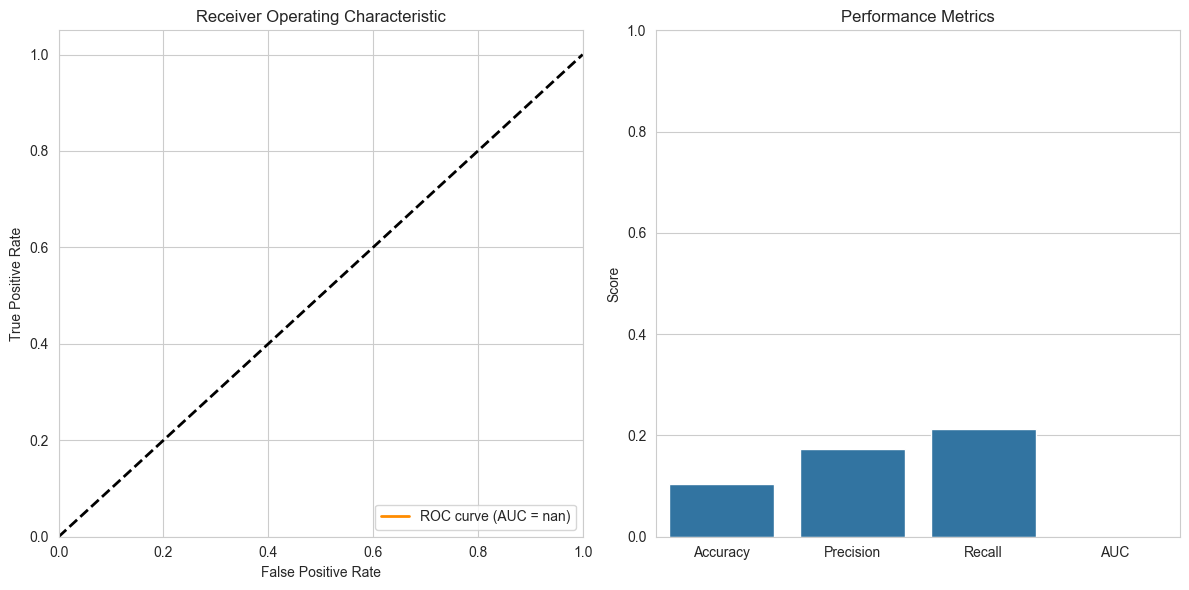


Numerical Results:
Accuracy:  0.103
Precision: 0.173
Recall:    0.213


In [8]:
# Example usage
metrics_plot = plot_metrics_and_roc(BM_df , score_column='Avg Similarity',threshold = 0.8)
metrics_plot.show()

# Print numerical results
print("\nNumerical Results:")
print(f"Accuracy:  {BM_df['Accuracy'].mean():.3f}")
print(f"Precision: {BM_df['Precision'].mean():.3f}")
print(f"Recall:    {BM_df['Recall'].mean():.3f}")